<h1 align="center">Time Series</h1>
<h3 align="center">Dataset: <a href="https://www.kaggle.com/c/competitive-data-science-predict-future-sales">Competitive data science: Predict future sales</a></h3>

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics       import mean_squared_error
import lightgbm as lgb

from itertools import product
import gc
import time

from ipywidgets import interact

In [2]:
!ls ../data/predict-future-sales

item_categories.csv       sales_train.csv.zip       shops.csv
items.csv.zip             sample_submission.csv.zip test.csv.zip


## Datos diarios de ventas desde Enero 2013 hasta Octubre 2015.

In [3]:
path = "../data/predict-future-sales/"

t = time.time()
train = pd.read_csv(path+"sales_train.csv.zip") # ventas diarias  Enero 2013 -> Octubre 2015
shops = pd.read_csv(path+"shops.csv")           # tiendas    (60)
items = pd.read_csv(path+"items.csv.zip")       # productos  (22170)
cats  = pd.read_csv(path+"item_categories.csv") # categorias de productos (84)
test  = pd.read_csv(path+"test.csv.zip", index_col="ID") # predicir Noviembre 2015
sub   = pd.read_csv(path+"sample_submission.csv.zip", index_col="ID")
print(round(time.time() - t,2), "secs")

1.69 secs


- **`sales_train.csv`** Filas: 2935849 ventas (Enero 2013 --> Octubre 2015)
  - **date**: date in format dd/mm/yyyy
  - **date_block_num**: a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
  - **shop_id**: unique identifier of a shop
  - **item_id**: unique identifier of a product
  - **item_price**: current price of an item
  - **item_cnt_day**: number of products sold. You are predicting a monthly amount of this measure
- **`shops.csv`** Filas: 60 tiendas
  - **shop_id**
  - **shop_name**: name of shop (EN RUSO 🇷🇺)
- **`items.csv`** Filas: 22170 productos
  - **item_id**
  - **item_name**: name of item (EN RUSO 🇷🇺)
  - **item_category_id**: unique identifier of item category
- **`item_categories.csv`** Filas: 84 categorías de producto
  - **item_category_id**
  - **item_category_name**: name of item category (EN RUSO 🇷🇺)
- **`test.csv`** Filas 214200 pares unicos de (Shop, Item)
  - **ID**: an Id that represents a (Shop, Item) tuple within the test set
  - **shop_id**
  - **item_id**

In [4]:
train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [5]:
train.tail(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


# Objetivo Concurso Kaggle: Calcular Noviembre 2015
### Sólo tiene tienda y producto, pero no cantidades vendidas

In [5]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [6]:
#itemsProfile = pandas_profiling.ProfileReport(items)
#itemsProfile.to_file(outputfile="./DATA/items.html")

#shopsProfile = pandas_profiling.ProfileReport(shops)
#shopsProfile.to_file(outputfile="./DATA/shops.html")

#catsProfile = pandas_profiling.ProfileReport(cats)
#catsProfile.to_file(outputfile="./DATA/item_categories.html")

#trainProfile = pandas_profiling.ProfileReport(train)
#trainProfile.to_file(outputfile="./DATA/sales_train_v2.html")

#testProfile = pandas_profiling.ProfileReport(test)
#testProfile.to_file(outputfile="./DATA/test.html")

# Outliers - valores atípicos :
### Son observaciones cuyos valores son muy diferentes a las otras observaciones del mismo grupo de datos
- Gestión de valores nulos: origen, eliminar registros con valores nulos, imputar valores
- Columnas duplicadas ej. km - millas
- Columnas con un valor único
- ...

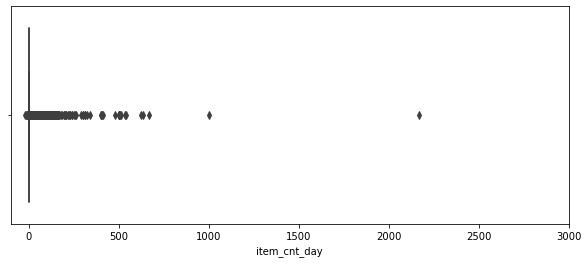

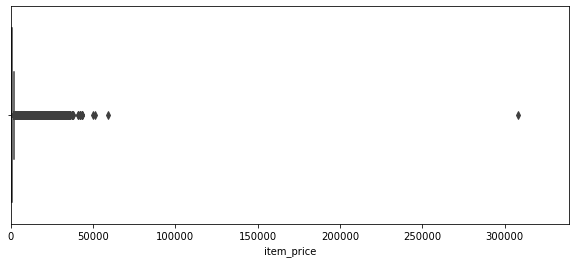

In [7]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sb.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sb.boxplot(x=train.item_price);

In [8]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

# Precios negativos

In [9]:
train.loc[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [10]:
# ver otros precios para ese mes, tienda y producto
train[(train.shop_id==32)&
      (train.item_id==2973)&
      (train.date_block_num==4)&
      (train.item_price>0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.0,1.0
484684,06.05.2013,4,32,2973,2499.0,1.0


In [11]:
# Asignar la media al precio negativo
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median
print(median)

1874.0


# Tiendas Duplicadas

In [12]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
#test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
#test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
#test.loc[test.shop_id == 10, 'shop_id'] = 11

# Tratamiento de Tiendas, Categorías y Productos

In [13]:
shops.head(21)  #Москва --> Moscú

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [14]:
ts = time.time()
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"' #rectificar el nombre de la tienda
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0]) #dividir el nombre de la tienda por el espacio
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'  #rectificar el nombre de la ciudad
shops['city_code'] = LabelEncoder().fit_transform(shops['city']) #codificar las tiendas
shops = shops[['shop_id','city_code']]
time.time() - ts

0.01472783088684082

In [15]:
shops.head(21)

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2
5,5,3
6,6,4
7,7,4
8,8,4
9,9,5


In [16]:
cats.head() #Аксессуары - PS2 --> Accesorios PS2

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [17]:
ts = time.time()
cats['split'] = cats['item_category_name'].str.split('-') #dividir el nombre de la categoría por '-'
cats['type'] = cats['split'].map(lambda x: x[0].strip()) #primera parte tipo de categoría
cats['type_code'] = LabelEncoder().fit_transform(cats['type']) # codificar

cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip()) #segunda parte subtipo
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]
time.time() - ts

0.015991926193237305

In [18]:
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [19]:
items['item_name'].head(30)

0             ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D
1     !ABBYY FineReader 12 Professional Edition Full...
2         ***В ЛУЧАХ СЛАВЫ   (UNV)                    D
3       ***ГОЛУБАЯ ВОЛНА  (Univ)                      D
4           ***КОРОБКА (СТЕКЛО)                       D
5     ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)         ...
6              ***УДАР ПО ВОРОТАМ (UNI)               D
7            ***УДАР ПО ВОРОТАМ-2 (UNI)               D
8              ***ЧАЙ С МУССОЛИНИ                     D
9         ***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI)             D
10            *ЗА ГРАНЬЮ СМЕРТИ                       D
11            *ЛИНИЯ СМЕРТИ                           D
12                      *МИХЕЙ И ДЖУМАНДЖИ  Сука любовь
13            *СПАСАЯ ЭМИЛИ                           D
14            *ЧОКНУТЫЙ ПРОФЕССОР /МАГИЯ/             D
15               //АДРЕНАЛИН: ОДИН ПРОТИВ ВСЕХ (Регион)
16                           //МОНГОЛ С.Бодров (Регион)
17                      //НЕ ОСТАВЛЯЮЩИЙ СЛЕДА (

In [20]:
items.drop(['item_name'], axis=1, inplace=True) 
#en esta demo no hacemos uso del nombre del producto, pero se podría crear un diccionario de palabras

# Matriz - Todos los productos para todas las tiendas y todos los meses
- hay productos que no aparecen para algunos meses y tiendas, y se deben rellenar con cero
- calcular la suma de ventas por mes - trabajamos por meses
- recortar a 20 es una recondemación de los organizadores del concurso
- rellenar a cero los valores nulos

In [21]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

12.048150062561035

In [22]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4


# Crear variables históricas ventas de meses anteriores

In [23]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [24]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

18.510337829589844

In [25]:
matrix[matrix.date_block_num > 11].head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
4488710,12,2,27,0.0,0,19,5,10,0.0,0.0,0.0,0.0,1.0
4488711,12,2,30,0.0,0,40,11,4,0.0,0.0,0.0,0.0,NaN
4488712,12,2,31,0.0,0,37,11,1,0.0,0.0,0.0,0.0,NaN
4488713,12,2,32,1.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0
4488714,12,2,33,1.0,0,37,11,1,1.0,2.0,0.0,0.0,1.0


# Variables agrupadas (cuidado con la fuga de datos)
La fuga de datos puede hacer que cree modelos predictivos demasiado optimistas, pero realmente son completamente inválidos.

La fuga de datos se produce cuando se utiliza información de fuera del conjunto de datos de capacitación para crear el modelo. Esta información adicional puede permitir que el modelo aprenda o sepa algo que de otro modo no sabría y, a su vez, invalidará el rendimiento estimado del modo que se está construyendo.

In [26]:
ts = time.time()
#la media Nºde ventas agrupado por mes
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)
#del mes anterior, se elimina la columna FUGA DE DATOS
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

#la media Nºde ventas agrupado por mes y producto
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

#la media Nºde ventas agrupado por mes y tienda
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

#la media Nºde ventas agrupado por mes y categoría
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

#la media Nºde ventas agrupado por mes, tienda y  categoría
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

#la media Nºde ventas agrupado por mes, tienda y tipo
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

#la media Nºde ventas agrupado por mes, tienda y subtipo
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

#la media Nºde ventas agrupado por mes y ciudad
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

#la media Nºde ventas agrupado por mes, producto y ciudad
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

#la media Nºde ventas agrupado por mes y tipo
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

#la media Nºde ventas agrupado por mes y subtipo
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

114.14073729515076

In [27]:
matrix[matrix.date_block_num > 11].head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
4488710,12,2,27,0.0,0,19,5,10,0.0,0.0,...,0.096008,0.141235,1.082031,0.955566,0.808594,0.935059,0.148071,0.0,1.03418,1.075195
4488711,12,2,30,0.0,0,40,11,4,0.0,0.0,...,0.096008,NaN,0.291504,0.046234,0.051727,0.046234,0.148071,0.0,0.27002,0.291504
4488712,12,2,31,0.0,0,37,11,1,0.0,0.0,...,0.096008,NaN,0.232788,0.059448,0.051727,0.064697,0.148071,0.0,0.27002,0.234009
4488713,12,2,32,1.0,0,40,11,4,0.0,0.0,...,0.096008,0.141235,0.291504,0.046234,0.051727,0.046234,0.148071,0.0,0.27002,0.291504
4488714,12,2,33,1.0,0,37,11,1,1.0,2.0,...,0.096008,0.141235,0.232788,0.059448,0.051727,0.064697,0.148071,1.0,0.27002,0.234009


# Tendencia de precios en los últimos seis meses.
### Delta Precio = (Precio Medio Producto agrupado por mes - Precio Medio Producto) / Precio Medio Producto

In [28]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

#primer histórico distinto de cero, partimos que no tenemos el precio de los productos para el mes de validación   
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)
time.time() - ts

KeyboardInterrupt: 

In [ ]:
matrix.head()

# Tendencia de ingresos de la tienda del mes pasado

In [ ]:
ts = time.time()
train['revenue'] = train['item_price'] *  train['item_cnt_day'] #ingresos precio * ventas

group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

In [ ]:
matrix.head()

# Mes y nº días

In [ ]:
matrix['month'] = matrix['date_block_num'] % 12


days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

# Nº meses desde la última venta por producto y tienda, y por producto

In [ ]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id) #por producto y tienda
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num
        
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id  #solo por producto
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num            
time.time() - ts

# Nº meses desde la primera venta por producto y tienda, y por producto

In [ ]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

# Quitamos los primeres 12 meses
### No tienen valores históricos

In [ ]:
matrix = matrix[matrix.date_block_num > 11]

# Rellenamos a cero posibles valores a nulo

In [ ]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

In [ ]:
matrix.head()

In [ ]:
matrix.columns

In [ ]:
matrix.info()

# Guardamos los datos

In [ ]:
ts = time.time()
matrix.to_pickle('./data/data.pkl')

del matrix
del group
del items
del shops
del cats
del train
del cache

gc.collect();
time.time() - ts

# Separación de datos de entrenamiento y validación

In [ ]:
ts = time.time()
data = pd.read_pickle('./data/data.pkl')
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
time.time() - ts

# Entrenamiento

In [ ]:
ts = time.time()
'''
#0.7875788072832439
params = {'bagging_fraction': 0.99, 'bagging_freq': 8, 'bagging_seed': SEED, 
          'feature_fraction': 0.6802441991432773, 'feature_fraction_seed': SEED, 
          'lambda_l1': 200, 'lambda_l2': 200, 'learning_rate': 0.015, 'max_bin': 176, 
          'metric': 'rmse', 'min_child_samples': 656,
          'min_child_weight': 636, 'min_split_gain': 0.1512409762978552, 'nthread': 8, 
          'num_leaves': 454, 'objective': 'mse', 'verbose': 0}
'''
SEED = 3246584
#0.7838050006725876
params = {'bagging_fraction': 0.5923685197548111, 'bagging_freq': 8, 'bagging_seed': SEED, 
          'feature_fraction': 0.6471558662772907, 'feature_fraction_seed': SEED, 
          'lambda_l1': 8, 'lambda_l2': 454, 'learning_rate': 0.15007983998456081, 'max_bin': 899, 
          'metric': 'rmse', 'min_child_samples': 463,
          'min_child_weight': 578, 'min_split_gain': 0.21257474291512948, 'nthread': 8, 
          'num_leaves': 278, 'objective': 'mse', 'verbose': 0}




evals_result = {}
model = lgb.train(params, 
            train_set=lgb.Dataset(X_train, label=Y_train), 
            num_boost_round=50000,
            valid_sets=[lgb.Dataset(X_train, label=Y_train), lgb.Dataset(X_valid, label=Y_valid)] ,
            valid_names=['train', 'val'],
            evals_result=evals_result,
            verbose_eval=50,
            early_stopping_rounds=400)
time.time() - ts

In [ ]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

In [ ]:
print('Plotting feature importances...')
ax = lgb.plot_importance(model, max_num_features=15)
plt.show()

In [ ]:
ax = lgb.plot_tree(model, tree_index=0, figsize=(20, 8), show_info=['split_gain'])
plt.show()

In [ ]:
for i in range(4):
    graph = lgb.create_tree_digraph(model, tree_index=i, name='./trees/Tree' + str(i))
    graph.render(view=False)

# Predicción

In [ ]:
Y_valid_predict = model.predict(X_valid, num_iteration=model.best_iteration).clip(0, 20)

rmseAux = mean_squared_error(Y_valid, Y_valid_predict)
print (rmseAux)

submission = pd.DataFrame({
    "shop_id": X_valid['shop_id'],
    "item_id": X_valid['item_id'], 
    "item_cnt_month": Y_valid,
    "predict": Y_valid_predict,
    "predict_round": Y_valid_predict.round(),
    "difference": (Y_valid - Y_valid_predict.round())
})
submission.to_csv('lgb_submission.csv', index=False)

In [ ]:
submission['difference'].describe()

In [ ]:
print ("Nº registros: ", submission['difference'].count())
print ("Nº aciertos: ", submission[submission.difference == 0]['difference'].count())

In [ ]:
submission[submission.item_cnt_month > 3].sample(20, random_state =3333) #101, 5555, 3333

In [ ]:
ax = sns.distplot(submission['difference'])

In [ ]:
ax = sns.distplot(submission[submission.shop_id == 2]['difference'])

In [ ]:
ax = sns.distplot(submission[submission.item_id == 30]['difference'])

In [ ]:
shops = sorted(submission['shop_id'].unique().tolist())

@interact(shopid=shops)
def DiffShops(shopid):
     ax = sns.distplot(submission[submission.shop_id == shopid]['difference'])

In [ ]:
items = sorted(submission['item_id'].unique().tolist())

@interact(itemid=items)
def DiffItems(itemid):
     ax = sns.distplot(submission[submission.item_id == itemid]['difference'])